In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp
import sympy

import mpmath

from matplotlib import rc

import utils

mpmath.mp.dps = 25

In [2]:
labelsize = 14
figsize = (5, 4.5)
ext = "eps"
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
params = {
    'figure.figsize': figsize,
    'font.size' : 12,
    'axes.labelsize': labelsize,
    'legend.fontsize': 12,
}
plt.rcParams.update(params)
workdir = 'figures/conduit_flow'
utils.make_dir_if_missing(workdir)

In [3]:
def get_schwarz_christoffel_parameters(s_over_w, h_over_w):
    t = h_over_w
    s = s_over_w
    # imaginary quarter period
    K1 = 1 + s/2

    # real quarter period                                                            
    K2 = t

    Krat = 2*K2/K1

    # elliptic nome
    q = np.exp(-np.pi*Krat)

    # inverse elliptic nome - solve for k
    k = float(mpmath.kfrom(q=q))

    # solve for dimensions
    K = mpmath.ellipk(k**2)
    L = 2 * K
    h = mpmath.ellipk(1 - k**2)
    s = s_over_w / h_over_w * h
    # print(L, h, s)

    b = 1/k

    # u = 0.5 * s
    # print(u, k)
    # a = mpmath.ellipfun('sn', u=u, q=q)
    # A = 2e-5/(0.5*(L - s))
    Cf = K1/2/K
    z1 = -K1/2 + K2*1j;
    z2 =  -K1/2
    z3 =  K1/2 - 1
    z4 = K1/2
    # print(z1, z2, z3, z4)
    za = mpmath.ellipfun('sn', u=z1/Cf, q=q)
    zb = mpmath.ellipfun('sn', u=z2/Cf, q=q)
    zc = mpmath.ellipfun('sn', u=z3/Cf, q=q)
    zd = mpmath.ellipfun('sn', u=z4/Cf, q=q)
    Dv = np.real((zc - za)/(zc - zb) / ((zd - za)/(zd - zb)))
    m2 = float(np.real((np.sqrt(Dv) - np.sqrt(Dv - 1)) ** 4))
    # print(m2)
    Krat2 = mpmath.ellipk(1 - m2)/sp.ellipk(m2)
    resist = 4/Krat2
    # print(resist)
    return resist
    # return A, a, b

In [4]:
get_schwarz_christoffel_parameters(s_over_w=0.1, h_over_w=10)

mpf('0.7895894135305657159032553498')

In [5]:
h_over_ws = [0.01, 0.1, 1.0, 2.0, 10]
s_over_ws = np.arange(0.01, 10.01, step=0.01)
print(s_over_ws[-1])

10.0


In [6]:
def get_chi_im_max(a):
    x = sympy.Symbol('x', real=True)
    integ = sympy.Integral(1/((x**2 - 1) * (x**2 - a**2)) ** 0.5, (x, -1, a)).evalf()
    print(integ)
    re = sympy.re(integ)
    im = sympy.im(integ)

    return re


def Rtilde(a, b, A=1, prefactor=1):
    """
    Dimensionless flow rate
    """
    chi_im_max = get_chi_im_max(a)
    # print(chi_im_max)
    x = sympy.Symbol('x', real=True)
    integ = (1/A) * sympy.Integral(((b**2 - x**2) ** 0.5) / ((x**2 - a ** 2) ** 0.5), (x, a, 1)).evalf()
    re = sympy.re(integ)
    im = sympy.im(integ)
    r_non_dim = prefactor * chi_im_max / re
    if not r_non_dim.is_real:
        return np.nan
    return r_non_dim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


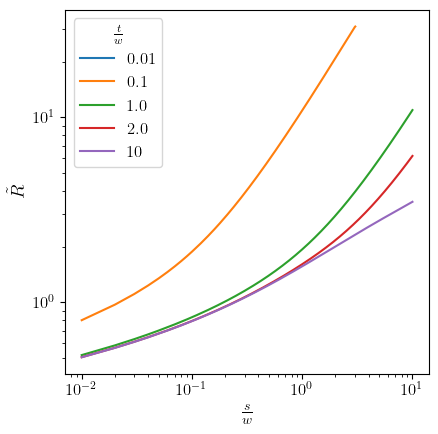

In [7]:
fig, ax = plt.subplots()
for t_over_w in h_over_ws:
    rtildes = []
    for s_over_w in s_over_ws:
        # A, a, b = get_schwarz_christoffel_parameters(s_over_w=s_over_w, h_over_w=t_over_w)
        try:
            rtilde = get_schwarz_christoffel_parameters(s_over_w=s_over_w, h_over_w=t_over_w)
        except Exception as e:
            rtilde = np.nan
        # rtilde = Rtilde(a, b, A=A, prefactor=0.1)
        # print("*****************")
        # print(rtilde)
        rtildes.append(rtilde)
    ax.plot(s_over_ws, rtildes, label=f'{t_over_w}')
ax.legend(title=r'$\frac{t}{w}$');
ax.set_box_aspect(1);
ax.set_xlabel(r'$\frac{s}{w}$');
ax.set_ylabel(r'$\tilde{R}$');
ax.minorticks_on();
ax.semilogx();
ax.semilogy();
plt.tight_layout();
plt.savefig(f'{workdir}/rtilde-new.{ext}', format=ext);